In [1]:
import itertools
import os
import string
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO

from tqdm import tqdm
import pandas as pd

import esm

from utils.file import save_np, read_json2list
from params.PDBparser import *

torch.set_grad_enabled(False)

In [2]:
print(torch.__version__)

2.0.1


In [3]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /home/dimeng/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /home/dimeng/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [6]:
df_entityFeature30 = csv2df(path_pdb_featureEntity30)

# entyID_entityID
PDB_IDS = df_entityFeature30['id'].tolist()

In [11]:
list_entity = read_json2list(path_IDRdataset)   

In [13]:
entity = list_entity[0]
entity

{'id': '4DZO_1',
 'sequence': 'GSSKEVAELKKQVESAELKNQRLKEVFQTKIQEFRKACYTLTGYQIDITTENQYRLTSLYAEHPGDCLIFKATSPSGSKMQLLETEFSHTVGELIEVHLRRQDSIPAFLSSLTLELFSRQTVA',
 'reference': '000000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000'}

In [35]:
for entity in list_entity:
    print(entity['id'])
    data = [(entity['id'], entity['sequence'])]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    embedded_seq = token_representations[0].numpy()
    # save the embedding
    save_np(embedded_seq, os.path.join(path_embedded_esm2, f"{entity['id']}.npy"))

4DZO_1


NameError: name 'path_embedded_esm2' is not defined

In [21]:
data = [(entity['id'], entity['sequence']), (list_entity[1]['id'], list_entity[1]['sequence'])]

In [22]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

In [28]:
# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [32]:
token_representations[0].size()

torch.Size([146, 1280])

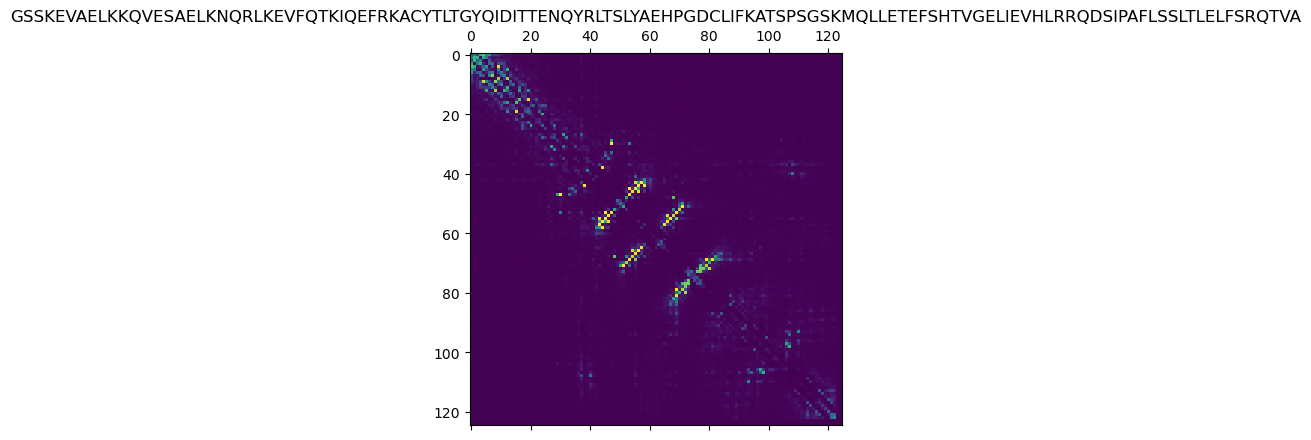

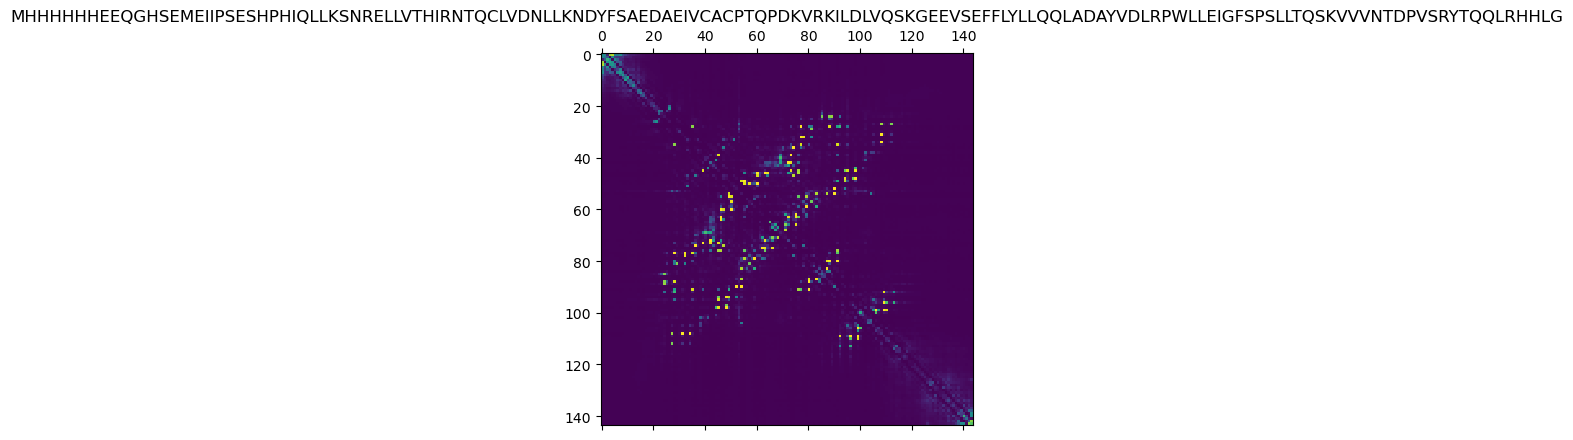

In [24]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()